_Last Updated: 06/10/2021_

In [43]:
import gurobipy as gp
from gurobipy import GRB, abs_
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [44]:
x = np.array([[0,0],[0,1], [1,0], [1,1]])
y = np.array([0,1,1,0])

### Langrangian Dual Subproblems

In [45]:
N = y.shape[0]
D = x[0].shape[0]
K = 2 # Number of units in each hidden layer
L = 3 # Number of hidden layers

w_ub, w_lb, b_ub, b_lb = [1,-1,1,-1]
epsilon = 0.01
reg_factor1 = 0.1
reg_factor2 = 0.1
reg_factor3 = 0.1

In [46]:
def zeta_0(λ):
    
    D = x[0].shape[0] # dimension of data

    # Create a new model
    m = gp.Model("0-th layer")
    
    # Create variables
    
    alpha = {}
    abs_alpha = {}
    beta = {}
    h = {}

    for k in range(K):
        beta[(k,0)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,0)))
        for d in range(D):
            alpha[(d,k,0)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((d,k,0)))
            abs_alpha[(d,k,0)] = m.addVar(lb=0, ub=w_ub, vtype=GRB.CONTINUOUS, name="abs_alpha"+str((d,k,0)))
            
        for n in range(N):
            h[(n,k,0)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,0)))
            
    # Set objective

    m.setObjective( 
        sum( sum( sum( 
        h[(n,k_prime,0)]*(-(-w_ub)*λ[(2,n,k_prime,k,1)]             # m is -w_ub
                           + w_lb*λ[(3,n,k_prime,k,1)]              # m is w_lb
                           - w_ub*λ[(4,n,k_prime,k,1)])             # M is w_ub
            for k in range(K)) for k_prime in range(K)) for n in range(N))
        + reg_factor1*sum( sum ( abs_alpha[(d,k,0)]  for k in range(K)) for d in range(D)),
                   GRB.MINIMIZE)
        
   # Add constraints 
    
    for n in range(N):
        for k in range(K):
            m.addConstr(sum(alpha[(d,k,0)]*x[n,d] for d in range(D)) + beta[(k,0)] 
                        <= -epsilon + (D*w_ub+b_ub + epsilon)*h[(n,k,0)], name="C1 Binary Neuron "+str((n,k,0)))
            
            m.addConstr(sum(alpha[(d,k,0)]*x[n,d] for d in range(D)) + beta[(k,0)] 
                        >= epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k,0)]), name="C2 Binary Neuron "+str((n,k,0)))
    
    for k in range(K):
        for d in range(D):
            m.addConstr(alpha[(d,k,0)] <= abs_alpha[(d,k,0)])
            m.addConstr(-alpha[(d,k,0)] <= abs_alpha[(d,k,0)])
            
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
        if "abs_alpha" in v.varName:
            continue
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


In [47]:
def zeta_l(layer, λ):
    
    # Create a new model
    m = gp.Model("l-th layer")
    
    l = layer # layer to be solved for
    
    # Create variables

    z = {}
    alpha = {}
    abs_alpha = {}
    beta = {}
    h = {}
    
    for k in range(K):
        for n in range(N):
            for k_prime in range(K):
                z[(n,k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,l)))
                
            h[(n,k,l)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l)))
        
        for k_prime in range(K):
            alpha[(k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,k,l)))
            abs_alpha[(k_prime,k,l)] = m.addVar(lb=0, ub=w_ub, vtype=GRB.CONTINUOUS, name="abs_alpha"+str((k_prime,k,l)))
        
        beta[(k,l)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,l)))
        
    # Set objective
        
    m.setObjective( 
        sum( sum( sum( 
            z[(n,k_prime,k,l)]*(- λ[(2,n,k_prime,k,l)] 
                                - λ[(3,n,k_prime,k,l)] 
                                + λ[(4,n,k_prime,k,l)])
            + h[(n,k_prime,l)]*(-(-w_ub)*λ[(2,n,k_prime,k,l+1)]            # m is w_lb-w_ub
                                + w_lb*λ[(3,n,k_prime,k,l+1)]              # m is w_lb
                                - w_ub*λ[(4,n,k_prime,k,l+1)])             # M is w_ub
            + alpha[(k_prime,k,l)]*(λ[(2,n,k_prime,k,l)])
            for k in range(K)) for k_prime in range(K)) for n in range(N))
        + reg_factor2*sum( sum ( abs_alpha[(k_prime,k,l)] for k in range(K)) for k_prime in range(K))
        , GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        for k in range(K):
            m.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + beta[(k,l)] 
                        <= -epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="C1 Binary Neuron "+str((n,k,l))) 

            m.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + beta[(k,l)] 
                        >= epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="C2 Binary Neuron "+str((n,k,l)))
            
            for k_prime in range(K):
                m.addConstr(z[(n,k_prime,k,l)] <= alpha[(k_prime,k,l)], name="Explicit z-alpha Bound "+str((n,k_prime,k,l)))
    
    for k in range(K):
        for k_prime in range(K):
            m.addConstr(alpha[(k_prime,k,l)] <= abs_alpha[(k_prime,k,l)])
            m.addConstr(-alpha[(k_prime,k,l)] <= abs_alpha[(k_prime,k,l)])
    
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
        if "abs_alpha" in v.varName:
            continue
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


In [48]:
def zeta_penultimate_L(λ):
    
    # Create a new model
    m = gp.Model("L-1st layer")
        
    # Create variables
    
    z = {}
    alpha = {}
    abs_alpha = {}
    beta = {}
    h = {}
    
    for k in range(K):
        for n in range(N):
            for k_prime in range(K):
                z[(n,k_prime,k,L-1)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,L-1)))
                
            h[(n,k,L-1)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,L-1)))
        
        for k_prime in range(K):
            alpha[(k_prime,k,L-1)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,k,L-1)))
            abs_alpha[(k_prime,k,L-1)] = m.addVar(lb=0, ub=w_ub, vtype=GRB.CONTINUOUS, name="abs_alpha"+str((k_prime,k,L-1)))
            
        beta[(k,L-1)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,L-1)))
        
    # Set objective
    
    m.setObjective( 
        sum( sum( sum( 
            z[(n,k_prime,k,L-1)]*(- λ[(2,n,k_prime,k,L-1)]
                                  - λ[(3,n,k_prime,k,L-1)]
                                  + λ[(4,n,k_prime,k,L-1)]) 
            + alpha[(k_prime,k,L-1)]*(λ[(2,n,k_prime,k,L-1)]) for k in range(K))
                 + h[(n,k_prime,L-1)]*(-(-w_ub)*λ[(2,n,k_prime,0,L)]              # m is -w_ub
                                       + w_lb*λ[(3,n,k_prime,0,L)]                # m is w_lb
                                       - w_ub*λ[(4,n,k_prime,0,L)])               # M is w_ub
                 for k_prime in range(K)) for n in range(N))
        + reg_factor2*sum( sum( abs_alpha[(k_prime,k,L-1)] for k in range(K)) for k_prime in range(K))
        , GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        for k in range(K):
            m.addConstr(sum(z[(n,k_prime,k,L-1)] for k_prime in range(K)) + beta[(k,L-1)] 
                        <= -epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,L-1)], name="C1 Binary Neuron "+str((n,k,L-1))) 

            m.addConstr(sum(z[(n,k_prime,k,L-1)] for k_prime in range(K)) + beta[(k,L-1)] 
                        >= epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,L-1)]), name="C2 Binary Neuron "+str((n,k,L-1)))
        
            for k_prime in range(K):
                m.addConstr(z[(n,k_prime,k,L-1)] <= alpha[(k_prime,k,L-1)], name="Explicit z-alpha Bound "+str((n,k_prime,k,L-1)))

    for k in range(K):
        for k_prime in range(K):
            m.addConstr(alpha[(k_prime,k,L-1)] <= abs_alpha[(k_prime,k,L-1)])
            m.addConstr(-alpha[(k_prime,k,L-1)] <= abs_alpha[(k_prime,k,L-1)])
    
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
        if "abs_alpha" in v.varName:
            continue
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


In [49]:
def zeta_L(λ):
    
    # Create a new model
    m = gp.Model("L-th layer")
        
    # Create variables
    
    z = {}
    alpha = {}
    abs_alpha = {}
    beta = {}
    y_hat = {}
    loss = {}
    
    for n in range(N):
        
        y_hat[n] = m.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss[n] = m.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="loss"+str(n))
        
        for k_prime in range(K):
            z[(n,k_prime,0,L)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,0,L)))
            
    beta[(0,L)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((0,L)))
    
    for k_prime in range(K):
        alpha[(k_prime,0,L)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,0,L)))
        abs_alpha[(k_prime,0,L)] = m.addVar(lb=0, ub=w_ub, vtype=GRB.CONTINUOUS, name="abs_alpha"+str((k_prime,0,L)))        
            
    # Set objective
    
    m.setObjective(
        sum(loss[n] + 
            sum(z[(n,k_prime,0,L)]*(- λ[(2,n,k_prime,0,L)]
                                    - λ[(3,n,k_prime,0,L)]
                                    + λ[(4,n,k_prime,0,L)]) 
                + alpha[(k_prime,0,L)]*(λ[(2,n,k_prime,0,L)]) for k_prime in range(K))
            for n in range(N))
        + reg_factor3*sum(abs_alpha[(k_prime,0,L)] for k_prime in range(K)), 
        GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        m.addConstr(sum(z[(n,k_prime,0,L)] for k_prime in range(K)) + beta[(0,L)] 
                    <= -epsilon + ((K*w_ub)+b_ub + epsilon)*y_hat[n], name="C1 Binary Neuron "+str((n,0,L))) 

        m.addConstr(sum(z[(n,k_prime,0,L)] for k_prime in range(K)) + beta[(0,L)] 
                    >= epsilon + ((K*w_lb)+b_lb - epsilon)*(1-y_hat[n]), name="C2 Binary Neuron "+str((n,0,L)))
        
        m.addConstr(loss[n] >= y[n] - y_hat[n], name = "C1 Loss Function"+str(n))
        m.addConstr(loss[n] >= -y[n] + y_hat[n], name = "C2 Loss Function"+str(n))
        
        for k_prime in range(K):
            m.addConstr(z[(n,k_prime,0,L)] <= alpha[(k_prime,0,L)], name="Explicit z-alpha Bound "+str((n,k_prime,0,L)))
                        
    for k_prime in range(K):
        m.addConstr(alpha[(k_prime,0,L)] <= abs_alpha[(k_prime,0,L)])
        m.addConstr(-alpha[(k_prime,0,L)] <= abs_alpha[(k_prime,0,L)])
    
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
        if "abs_alpha" in v.varName:
            continue
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


In [50]:
# def zeta_alpha_l(λ):
    
#     # Create a new model
#     m = gp.Model("alpha l-th layer")
        
#     # Create variables
    
#     alpha = {}
    
#     for k_prime in range(K):
#         for k in range(K):
#             for l in range(1,L):
#                 alpha[(k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,k,l)))
        
#     # Set objective
    
#     m.setObjective( sum( sum( sum( sum (
#         alpha[(k_prime,k,l)]*(-λ[(1,n,k_prime,k,l)]
#                              + λ[(2,n,k_prime,k,l)])
#                     for l in range(1,L)) for k in range(K)) for k_prime in range(K)) for n in range(N)), 
#                    GRB.MINIMIZE)
    
#     # Optimize
    
#     m.setParam('OutputFlag', 0) # uncomment to silence the output
#     m.optimize()
#     m.printQuality()
            
#     for v in m.getVars():
# #         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
#         output[v.varName] = v.x 

# #     print('Obj: %g' % m.objVal)
    
#     return(m.objVal)


In [51]:
# def zeta_alpha_L(λ):
    
#     # Create a new model
#     m = gp.Model("alpha l-th layer")
        
#     # Create variables
    
#     alpha = {}
    
#     for k_prime in range(K):
#         alpha[(k_prime,0,L)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,0,L)))
        
#     # Set objective
    
#     m.setObjective( sum( sum(
#         alpha[(k_prime,0,L)]*(-λ[(1,n,k_prime,0,L)]
#                              + λ[(2,n,k_prime,0,L)])
#                     for k_prime in range(K)) for n in range(N)), 
#                    GRB.MINIMIZE)
    
#     # Optimize
    
#     m.setParam('OutputFlag', 0) # uncomment to silence the output
#     m.optimize()
#     m.printQuality()
            
#     for v in m.getVars():
# #         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
#         output[v.varName] = v.x 

# #     print('Obj: %g' % m.objVal)
    
#     return(m.objVal)


### Solving the dual with the Subgradient algorithm

In [52]:

    ## initialize langrange multiplier

λ = {} 
        
for n in range(N):
    for k_prime in range(K):
        for k in range(K):
            for l in range(1,L):
#                 λ[(1,n,k_prime,k,l)] = 5
                λ[(2,n,k_prime,k,l)] = 1
                λ[(3,n,k_prime,k,l)] = 3
                λ[(4,n,k_prime,k,l)] = 6
#         λ[(1,n,k_prime,0,L)] = 7
        λ[(2,n,k_prime,0,L)] = 2
        λ[(3,n,k_prime,0,L)] = 1
        λ[(4,n,k_prime,0,L)] = 0

λ_array = list(λ.values())        

output = {} # dictionary of outputs

    ## Solve subproblems and find the dual objective

dual_obj = (zeta_0(λ) + sum(zeta_l(l,λ) for l in range(1,L-1)) + zeta_penultimate_L(λ) + zeta_L(λ)  
            + sum( sum( sum( sum(
                (-w_ub)*λ[(2,n,k_prime,k,l)] for l in range(1,L)) for k in range(K))
                       + (-w_ub)*λ[(2,n,k_prime,0,L)] for k_prime in range(K)) for n in range(N)))

    # removed lambda 1 from dual_obj

    ## Find the subgradient vector at λ

s = {}

for n in range(N):
    for k_prime in range(K):
        for k in range(K):
            for l in range(1,L):
#                 s[(1,n,k_prime,k,l)] = ( output['z'+str((n,k_prime,k,l))] - output['alpha'+str((k_prime,k,l))] 
#                                         - (w_ub-w_lb)*(1-output['h'+str((n,k_prime,l-1))]) )

                s[(2,n,k_prime,k,l)] = ( -output['z'+str((n,k_prime,k,l))] + output['alpha'+str((k_prime,k,l))] 
                                        + (w_lb-w_ub)*(1-output['h'+str((n,k_prime,l-1))]) )

                s[(3,n,k_prime,k,l)] = ( (w_lb)*output['h'+str((n,k_prime,l-1))] 
                                        - output['z'+str((n,k_prime,k,l))] )

                s[(4,n,k_prime,k,l)] = ( output['z'+str((n,k_prime,k,l))] 
                                        - (w_ub)*output['h'+str((n,k_prime,l-1))] )

#         s[(1,n,k_prime,0,L)] = ( output['z'+str((n,k_prime,0,L))] - output['alpha'+str((k_prime,0,L))] 
#                                 - (w_ub-w_lb)*(1-output['h'+str((n,k_prime,L-1))]) )

        s[(2,n,k_prime,0,L)] = ( -output['z'+str((n,k_prime,0,L))] + output['alpha'+str((k_prime,0,L))] 
                                + (-w_ub)*(1-output['h'+str((n,k_prime,L-1))]) )

        s[(3,n,k_prime,0,L)] = ( (w_lb)*output['h'+str((n,k_prime,L-1))] - output['z'+str((n,k_prime,0,L))] )

        s[(4,n,k_prime,0,L)] = ( output['z'+str((n,k_prime,0,L))] - (w_ub)*output['h'+str((n,k_prime,L-1))] )

s_array = np.array(list(s.values()))

    ## Simple Stepsize

# gamma = 1

    ## Adaptive Stepsize

mu_naught = 2
mu = mu_naught

Z_best = 0 # Lower bound on primal

gamma = mu*((Z_best - dual_obj)/(np.linalg.norm(s_array))**2)

    ## Track the projected subgradinet

indicator = []

for i in range(len(λ_array)):
    if (λ_array[i] + gamma*s_array[i]) > 0:
        indicator.append(1)
    else:
        indicator.append(0)

indicator = np.array(indicator)
projected_s = indicator.T*s_array

if (dual_obj >= -1e-6) and (dual_obj_tracker[t]-dual_obj_tracker[t-1] < 1e-6):
    print("The dual objective roughly optimal")
else:
    print("Proceed with the subgradient algorithm")

Proceed with the subgradient algorithm


In [53]:
subgradient_tracker = [np.linalg.norm(s_array)]
dual_obj_tracker = [dual_obj]
gamma_tracker = [gamma]
projected_s_tracker = [np.linalg.norm(projected_s)]
mu_tracker = [mu]

adapt_param_factor = 2/3 # try 1/4 and 2/3

T = 0 # Number of times Z_{D} did not increase

for t in range(1,1000): 

    if t%100 == 0:
        print("Iteration count:", t)
    
        ## Update λ
    
    for n in range(N):
            for k_prime in range(K):
                for k in range(K):
                    for l in range(1,L):
#                         λ[(1,n,k_prime,k,l)] = max(0, λ[(1,n,k_prime,k,l)] + gamma*s[(1,n,k_prime,k,l)])
                        λ[(2,n,k_prime,k,l)] = max(0, λ[(2,n,k_prime,k,l)] + gamma*s[(2,n,k_prime,k,l)])
                        λ[(3,n,k_prime,k,l)] = max(0, λ[(3,n,k_prime,k,l)] + gamma*s[(3,n,k_prime,k,l)])
                        λ[(4,n,k_prime,k,l)] = max(0, λ[(4,n,k_prime,k,l)] + gamma*s[(4,n,k_prime,k,l)])
#                 λ[(1,n,k_prime,0,L)] = max(0, λ[(1,n,k_prime,0,L)] + gamma*s[(1,n,k_prime,0,L)])
                λ[(2,n,k_prime,0,L)] = max(0, λ[(2,n,k_prime,0,L)] + gamma*s[(2,n,k_prime,0,L)])
                λ[(3,n,k_prime,0,L)] = max(0, λ[(3,n,k_prime,0,L)] + gamma*s[(3,n,k_prime,0,L)])
                λ[(4,n,k_prime,0,L)] = max(0, λ[(4,n,k_prime,0,L)] + gamma*s[(4,n,k_prime,0,L)])
                
    λ_array = np.array(list(λ.values()))

        ## Solve subproblems and find the dual objective

    dual_obj = (zeta_0(λ) + sum(zeta_l(l,λ) for l in range(1,L-1)) + zeta_penultimate_L(λ) + zeta_L(λ) 
                + sum( sum( sum( sum(
                    (-w_ub)*λ[(2,n,k_prime,k,l)] for l in range(1,L)) for k in range(K)) 
                           + (-w_ub)*λ[(2,n,k_prime,0,L)] for k_prime in range(K)) for n in range(N)))

    # removed lambda 1 from dual_obj
    
    dual_obj_tracker.append(dual_obj)

        ## Find the subgradient vector at λ
    
    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L):
#                     s[(1,n,k_prime,k,l)] = ( output['z'+str((n,k_prime,k,l))] - output['alpha'+str((k_prime,k,l))] 
#                                             - (w_ub-w_lb)*(1-output['h'+str((n,k_prime,l-1))]) )

                    s[(2,n,k_prime,k,l)] = ( -output['z'+str((n,k_prime,k,l))] + output['alpha'+str((k_prime,k,l))] 
                                            + (-w_ub)*(1-output['h'+str((n,k_prime,l-1))]) )

                    s[(3,n,k_prime,k,l)] = ( (w_lb)*output['h'+str((n,k_prime,l-1))] 
                                            - output['z'+str((n,k_prime,k,l))] )

                    s[(4,n,k_prime,k,l)] = ( output['z'+str((n,k_prime,k,l))] 
                                            - (w_ub)*output['h'+str((n,k_prime,l-1))] )

#             s[(1,n,k_prime,0,L)] = ( output['z'+str((n,k_prime,0,L))] - output['alpha'+str((k_prime,0,L))] 
#                                     - (w_ub-w_lb)*(1-output['h'+str((n,k_prime,L-1))]) )

            s[(2,n,k_prime,0,L)] = ( -output['z'+str((n,k_prime,0,L))] + output['alpha'+str((k_prime,0,L))] 
                                    + (-w_ub)*(1-output['h'+str((n,k_prime,L-1))]) )

            s[(3,n,k_prime,0,L)] = ( (w_lb)*output['h'+str((n,k_prime,L-1))] - output['z'+str((n,k_prime,0,L))] )

            s[(4,n,k_prime,0,L)] = ( output['z'+str((n,k_prime,0,L))] - (w_ub)*output['h'+str((n,k_prime,L-1))] )

    s_array = np.array(list(s.values()))
    subgradient_tracker.append(np.linalg.norm(s_array))
    
        ## Simple step-size
    
#     gamma = 1/np.sqrt(t) 
    
        ## Adaptive Polyak Stepsize

    if dual_obj > Z_best:
        Z_best = dual_obj
        
    if dual_obj < dual_obj_tracker[-2]:
        T += 1
    else:
        T = 0
    
    if T >= 2: # scaling mu if Z_{D} did not increase in the last 2 iterations
        mu = adapt_param_factor*mu
        
    mu_tracker.append(mu)
        
    gamma = mu*((Z_best - dual_obj)/(np.linalg.norm(s_array))**2)
    gamma_tracker.append(gamma)

        ## Track norm of projected subgradinet
    
    indicator = []

    for i in range(len(λ_array)):
        if (λ_array[i] + gamma*s_array[i]) < 0:
            indicator.append(0)
#             indicator[i] = 0
        else:
            indicator.append(1)
            
    indicator = np.array(indicator)
    projected_s = indicator.T*s_array

    projected_s_tracker.append(np.linalg.norm(projected_s))
        
    if (dual_obj >= -1e-5) and (dual_obj_tracker[t]-dual_obj_tracker[t-1] < 1e-6):
        break
        
        # The lower bound on the primal might not always be 0, but should be??
    
assert all((x <= 1e-4 and x >= -1e-4) for x in λ_array*s_array), "Complementary Slackness Conditions are not upheld"

# The product of dual variables and constraints is not exactly 0, but is approximately 0 
# (does not hold for [-1e-7,1e-7])


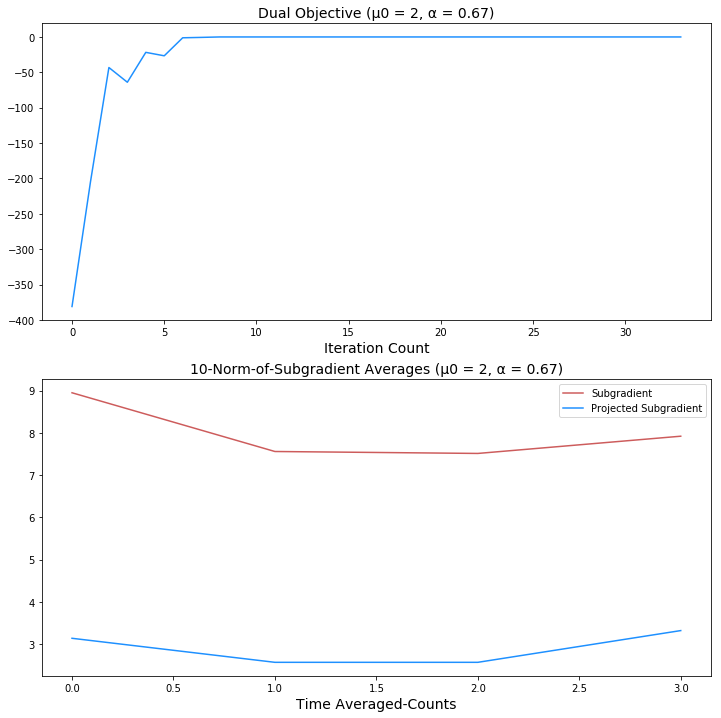

In [54]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(12, 12)

subgrad_y1 = [np.mean(subgradient_tracker[i:i+10]) for i in range(0,len(subgradient_tracker),10)]
subgrad_y2 = [np.mean(projected_s_tracker[i:i+10]) for i in range(0,len(projected_s_tracker),10)]

ax1.plot([x for x in range(t+1)], dual_obj_tracker, c="dodgerblue")
ax2.plot([x for x in range(len(subgrad_y1))], subgrad_y1, c="indianred")
ax2.plot([x for x in range(len(subgrad_y2))], subgrad_y2, c="dodgerblue")

ax1.set_title("Dual Objective (μ0 = {}, α = {})".format(np.round(mu_naught,2), np.round(adapt_param_factor,2)), fontsize=14)
ax2.set_title("10-Norm-of-Subgradient Averages (μ0 = {}, α = {})".format(np.round(mu_naught,2), np.round(adapt_param_factor,2)), fontsize=14)

ax2.legend(["Subgradient", "Projected Subgradient"])

ax1.set_xlabel('Iteration Count', fontsize=14)
ax2.set_xlabel('Time Averaged-Counts', fontsize=14)

filename = 'mu0={} alpha={}.png'.format(np.round(mu_naught,2), np.round(adapt_param_factor,2))
plt.savefig("Subgradient Plots/"+filename)

None

In [55]:
# with open("output.json", "w") as outfile: 
#     json.dump(output, outfile, indent = 4)

In [35]:
dual_obj

-8.632856715533596e-06

In [36]:
projected_s

array([-0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,
        0.   ,  0.   , -0.   , -0.   ,  0.01 , -0.99 , -0.   , -0.   ,
        0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,
        0.   , -0.   , -0.   ,  0.01 , -0.99 , -0.   , -0.   ,  0.   ,
        0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   ,
       -0.   , -0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,
        0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   ,
       -0.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   ,
       -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.505, -0.   , -0.   ,
        0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   ,
       -0.   , -0.   ,  0.   ,  0.   ,  0.505, -0.   , -0.   , -0.   ,
       -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,
       -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.01 , -0.99 ,
       -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,
      

In [37]:
s_array

array([-1.   ,  0.   ,  0.   ,  0.   , -1.   , -1.   , -1.   ,  0.   ,
        0.   ,  0.   , -1.   , -1.   ,  0.01 , -0.99 , -1.01 , -1.   ,
        0.   ,  0.   ,  0.   , -1.   , -1.   , -1.   ,  0.   ,  0.   ,
        0.   , -1.   , -1.   ,  0.01 , -0.99 , -1.01 , -1.   ,  0.   ,
        0.   ,  0.   , -1.   , -1.   , -1.   ,  0.   ,  0.   ,  0.   ,
       -1.   , -1.   ,  0.   , -1.   , -1.   , -1.   ,  0.   ,  0.   ,
        0.   , -1.   , -1.   , -1.   ,  0.   ,  0.   ,  0.   , -1.   ,
       -1.   ,  0.   , -1.   , -1.   , -1.   ,  0.   ,  0.   ,  0.   ,
       -1.   , -1.   , -1.   ,  0.   ,  0.   ,  0.505, -0.495, -1.505,
        0.   , -1.   , -1.   , -1.   ,  0.   ,  0.   ,  0.   , -1.   ,
       -1.   , -1.   ,  0.   ,  0.   ,  0.505, -0.495, -1.505, -1.   ,
       -0.   ,  0.   , -1.   ,  0.   ,  0.   ,  0.   , -1.   , -1.   ,
       -1.   ,  0.   ,  0.   ,  0.   , -1.   , -1.   ,  0.01 , -0.99 ,
       -1.01 , -1.   ,  0.   ,  0.   ,  0.   , -1.   , -1.   , -1.   ,
      

In [38]:
λ_array*s_array

array([-9.98177910e-08,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -9.98177910e-08, -0.00000000e+00, -9.98177910e-08,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.97658992e-07, -0.00000000e+00,
        1.41136143e-08, -1.47656814e-06, -0.00000000e+00, -9.98177910e-08,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -9.98177910e-08,
       -0.00000000e+00, -9.98177910e-08,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.97658992e-07, -0.00000000e+00,  1.41136143e-08,
       -1.47656814e-06, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.98177910e-08, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.97658992e-07, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -9.98177910e-08, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  

In [39]:
λ

{(2, 0, 0, 0, 1): 9.981779099928514e-08,
 (3, 0, 0, 0, 1): 0,
 (4, 0, 0, 0, 1): 0,
 (2, 0, 0, 0, 2): 0,
 (3, 0, 0, 0, 2): 9.981779099928514e-08,
 (4, 0, 0, 0, 2): 0,
 (2, 0, 0, 1, 1): 9.981779099928514e-08,
 (3, 0, 0, 1, 1): 0,
 (4, 0, 0, 1, 1): 0,
 (2, 0, 0, 1, 2): 0,
 (3, 0, 0, 1, 2): 1.9765899207779223e-07,
 (4, 0, 0, 1, 2): 0,
 (2, 0, 0, 0, 3): 1.4113614336257762e-06,
 (3, 0, 0, 0, 3): 1.4914829708139534e-06,
 (4, 0, 0, 0, 3): 0,
 (2, 0, 1, 0, 1): 9.981779099928514e-08,
 (3, 0, 1, 0, 1): 0,
 (4, 0, 1, 0, 1): 0,
 (2, 0, 1, 0, 2): 0,
 (3, 0, 1, 0, 2): 9.981779099928514e-08,
 (4, 0, 1, 0, 2): 0,
 (2, 0, 1, 1, 1): 9.981779099928514e-08,
 (3, 0, 1, 1, 1): 0,
 (4, 0, 1, 1, 1): 0,
 (2, 0, 1, 1, 2): 0,
 (3, 0, 1, 1, 2): 1.9765899207779223e-07,
 (4, 0, 1, 1, 2): 0,
 (2, 0, 1, 0, 3): 1.411361433625777e-06,
 (3, 0, 1, 0, 3): 1.4914829708139805e-06,
 (4, 0, 1, 0, 3): 0,
 (2, 1, 0, 0, 1): 0,
 (3, 1, 0, 0, 1): 0,
 (4, 1, 0, 0, 1): 0,
 (2, 1, 0, 0, 2): 0,
 (3, 1, 0, 0, 2): 9.981779099928514e-08,


In [40]:
s

{(2, 0, 0, 0, 1): -1.0,
 (3, 0, 0, 0, 1): 0.0,
 (4, 0, 0, 0, 1): 0.0,
 (2, 0, 0, 0, 2): 0.0,
 (3, 0, 0, 0, 2): -1.0,
 (4, 0, 0, 0, 2): -1.0,
 (2, 0, 0, 1, 1): -1.0,
 (3, 0, 0, 1, 1): 0.0,
 (4, 0, 0, 1, 1): 0.0,
 (2, 0, 0, 1, 2): 0.0,
 (3, 0, 0, 1, 2): -1.0,
 (4, 0, 0, 1, 2): -1.0,
 (2, 0, 0, 0, 3): 0.009999999999999893,
 (3, 0, 0, 0, 3): -0.9900000000000001,
 (4, 0, 0, 0, 3): -1.0099999999999998,
 (2, 0, 1, 0, 1): -1.0,
 (3, 0, 1, 0, 1): 0.0,
 (4, 0, 1, 0, 1): 0.0,
 (2, 0, 1, 0, 2): 0.0,
 (3, 0, 1, 0, 2): -1.0,
 (4, 0, 1, 0, 2): -1.0,
 (2, 0, 1, 1, 1): -1.0,
 (3, 0, 1, 1, 1): 0.0,
 (4, 0, 1, 1, 1): 0.0,
 (2, 0, 1, 1, 2): 0.0,
 (3, 0, 1, 1, 2): -1.0,
 (4, 0, 1, 1, 2): -1.0,
 (2, 0, 1, 0, 3): 0.009999999999999894,
 (3, 0, 1, 0, 3): -0.9900000000000001,
 (4, 0, 1, 0, 3): -1.0099999999999998,
 (2, 1, 0, 0, 1): -1.0,
 (3, 1, 0, 0, 1): 0.0,
 (4, 1, 0, 0, 1): 0.0,
 (2, 1, 0, 0, 2): 0.0,
 (3, 1, 0, 0, 2): -1.0,
 (4, 1, 0, 0, 2): -1.0,
 (2, 1, 0, 1, 1): -1.0,
 (3, 1, 0, 1, 1): 0.0,
 (4, 1, 0, 1

In [41]:
output

{'beta(0, 0)': -1.0,
 'alpha(0, 0, 0)': 0.0,
 'alpha(1, 0, 0)': 0.0,
 'h(0, 0, 0)': -0.0,
 'h(1, 0, 0)': -0.0,
 'h(2, 0, 0)': -0.0,
 'h(3, 0, 0)': -0.0,
 'beta(1, 0)': -1.0,
 'alpha(0, 1, 0)': 0.0,
 'alpha(1, 1, 0)': 0.0,
 'h(0, 1, 0)': -0.0,
 'h(1, 1, 0)': -0.0,
 'h(2, 1, 0)': -0.0,
 'h(3, 1, 0)': -0.0,
 'z(0, 0, 0, 1)': 0.0,
 'z(0, 1, 0, 1)': 0.0,
 'h(0, 0, 1)': 1.0,
 'z(1, 0, 0, 1)': 0.0,
 'z(1, 1, 0, 1)': 0.0,
 'h(1, 0, 1)': 1.0,
 'z(2, 0, 0, 1)': 0.0,
 'z(2, 1, 0, 1)': 0.0,
 'h(2, 0, 1)': 1.0,
 'z(3, 0, 0, 1)': 0.0,
 'z(3, 1, 0, 1)': 0.0,
 'h(3, 0, 1)': 1.0,
 'alpha(0, 0, 1)': 0.0,
 'alpha(1, 0, 1)': 0.0,
 'beta(0, 1)': 1.0,
 'z(0, 0, 1, 1)': 0.0,
 'z(0, 1, 1, 1)': 0.0,
 'h(0, 1, 1)': 1.0,
 'z(1, 0, 1, 1)': 0.0,
 'z(1, 1, 1, 1)': 0.0,
 'h(1, 1, 1)': 1.0,
 'z(2, 0, 1, 1)': 0.0,
 'z(2, 1, 1, 1)': 0.0,
 'h(2, 1, 1)': 1.0,
 'z(3, 0, 1, 1)': 0.0,
 'z(3, 1, 1, 1)': 0.0,
 'h(3, 1, 1)': 1.0,
 'alpha(0, 1, 1)': 0.0,
 'alpha(1, 1, 1)': 0.0,
 'beta(1, 1)': 1.0,
 'z(0, 0, 0, 2)': 0.0,
 'z(0, 

### Primal Feasible Solution

In [42]:
h = {} # tracks output of units

correct_pred = 0

for n in range(N):
    for k in range(K):
        h[(k,0)] = sum(output["alpha"+str((d,k,0))]*x[n,d] for d in range(D)) + output["beta"+str((k,0))]
#             print("h[",(k,0),"] = ", h[(k,0)])

        if h[(k,0)] <= 0:
            h[(k,0)] = 0
        else:
            h[(k,0)] = 1
#             print("h[",(k,0),"] = ", h[(k,0)])

    for l in range(1,L):
        for k in range(K):
            h[(k,l)] = sum(output["alpha"+str((k_prime,k,l))]*h[(k_prime,l-1)] for k_prime in range(K)) + output["beta"+str((k,l))]
#                 print("h[",(k,l),"] = ", h[(k,l)])

            if h[(k,l)] <= 0:
                h[(k,l)] = 0
            else:
                h[(k,l)] = 1
#                 print("h[",(k,l),"] = ", h[(k,l)])

    y_hat = sum(output["alpha"+str((k_prime,0,L))]*h[(k,L-1)] for k in range(K)) + output["beta"+str((0,L))]
    if y_hat <= 0:
        y_hat = 0
    else:
        y_hat = 1

    if y_hat == y[n]:
        correct_pred += 1
    
    print(x[n][0], "XOR", x[n][1], "=", float(y_hat), "Should be ", float(y[n]))

print("\nPrediction Accuracy = ", correct_pred/(n+1)*100, "%")

0 XOR 0 = 1.0 Should be  0.0
0 XOR 1 = 1.0 Should be  1.0
1 XOR 0 = 1.0 Should be  1.0
1 XOR 1 = 1.0 Should be  0.0

Prediction Accuracy =  50.0 %


### Notes and Questions for 06/01/2021

* The reformulation is not suited for $ L = 1 $, but seems to run for $ L \ge 2 $
* Verify that the subgradient is defined appropriately
* Explicit bounds on z in the sub-problems?
* $ -10^{-3} \le s \le 10^{-3} $ or just $ s \le 10^{-3} $ (neither seem to be converging)

### Notes and Questions for 06/08/2021

* Norm of subgradient is oscillating back and forth with every iteration; not reducing significantly with each iteration
* Dual objective is also oscillating but generally increasing quicker than the norm of the subgradient
* Step size seems to be the issue; Try the Held-Karp Stepsize

***

* Try projected subgradient: "calculate $ x = \lambda^{t} + \gamma^{t}s^{t} $, figure out which entries of that vector are negative and have an "indicator" vector (call this y for now) has the same length as x but whose entries equal 1 if the corresponding entry of x is non-negative and 0 otherwise. Then multiply $ Ax-b $ by y (i.e. $y^{T}(Ax-b)$) and take the norm of the result. This should go to zero. The reason being is due to the constraint."

***

* Dual Objective still decreasing first and then increasing. Having the same values for all λ in the 0th iteration is always giving the same dual objective. On the other hand, having $ \lambda^0 $ equal to a variety of values avoids this. Don't know why this means that the 1st iteration gives a better dual objective than when all the $ \lambda^0 $ are equal though.
* Projected subgradient still not converging to 0. 


***

##### TODO 06/08/2021
* Add a check for the complementary slackness conditions and seeing if they are all zero.  
* Add a check that if the objective doesn't change by too much after a few rounds (like objectives in consecutive iterations are within 1e-6 or 1e-4 of each other) then terminate the algorithm. 
* For the plots, add a time average for the sub gradient (like maybe a sliding window average of 10 iterations or something like that) just to smooth them out a bit and show the over all trajectory.
* Recreate a primal feasible solution form this and check the prediction accuracy. Take the values of the coefficients of the ANN from this procedure and let's see how an ANN with those values performs.

***

__Fixes__: 
* For the stepsize equation, fixed $ (||s|| \times 2) $ to $ (||s||^{2}) $ 
* Fixed adaption parameter scaling from every iteration to when $ Z_{D} $ did not increase in the last 2 iterations
* Fixed dual_obj sum from range(1,L-1) to range(1,L)

### Notes and Questions for 06/15/2021

* Add the explicit contraint $ z \leq \alpha $
    * This means that we can remove $ z - \alpha \leq M(1-h) $ from the formulation and from the dual.

--> Done. The new problem is that when $ \alpha = 1 $, z can still be anything it wants in the last layer. Also, we're not seeing $ z_l = 0 $ when $ h_{l-1} = 0 $

* Include a regularization term in the objective equal to $ \sum \mu(|\alpha|) $ (so minimize the absolute value of the sum of all the alphas times some constant mu that is small-ish like 0.1)
    * $ \mu $ should be outside of the summation?
    
* In the objectives, should it be $ h_{n,k\prime,l} $ or $ h_{n,k,l} $? Changing them makes a difference...